In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.pyplot as plt

In [117]:
instance = "instance_18.txt"

def dataframe_to_customers_dict(df):
    # DataFrame'den her bir satırı alıp, istenen sözlük formatına çevirir
    customers = [
        {
            'id': int(row['CUST NO.']),
            'x': int(row['XCOORD.']),
            'y': int(row['YCOORD.']),
            'demand': int(row['DEMAND']),
            'ready_time': int(row['READY TIME']),
            'due_date': int(row['DUE DATE']),
            'service_time': int(row['SERVICE TIME'])
        }
        for index, row in df.iterrows()
    ]
    return customers

all_instances = []
file_names = [ "instance_1.txt", "instance_2.txt", "instance_3.txt","instance_4.txt","instance_5.txt","instance_6.txt","instance_7.txt","instance_8.txt","instance_9.txt","instance_10.txt","instance_11.txt","instance_12.txt","instance_13.txt","instance_14.txt","instance_15.txt","instance_16.txt","instance_17.txt","instance_18.txt","instance_19.txt","instance_20.txt"]

with open(instance, 'r') as dosya:
    satirlar = dosya.readlines()

# Vehicle Capacity'yi al
vehicle_capacity = int(satirlar[1])

# Geri kalan satırları DataFrame'e dönüştürmek için uygun satırları seç
veri_satirlari = []
for satir in satirlar[6:]:  # Başlangıç satırı doğru ise
    temiz_satir = satir.strip()
    if temiz_satir:  # Boş olmayan satırları kontrol et
        parcalanmis_satir = temiz_satir.split()
        if len(parcalanmis_satir) == 7:  # Beklenen sütun sayısı kontrolü
            veri_satirlari.append(parcalanmis_satir)

df = pd.DataFrame(veri_satirlari, columns=["CUST NO.", "XCOORD.", "YCOORD.", "DEMAND", "READY TIME", "DUE DATE", "SERVICE TIME"])

for column in df.columns[1:]:  # "CUST NO." hariç diğer tüm sütunlar
    df[column] = df[column].astype(int)
customers = dataframe_to_customers_dict(df)

In [118]:
""" #Worst Case
customers = [
    {'id': 0, 'x': 50, 'y':60, 'demand': 0, 'ready_time': 0, 'due_date': 257, 'service_time': 0},
    {'id': 1, 'x': 60, 'y': 70, 'demand': 0, 'ready_time': 10, 'due_date': 14, 'service_time': 0},
    {'id': 2, 'x': 70, 'y': 80, 'demand': 0, 'ready_time': 20, 'due_date': 30, 'service_time': 0},
    {'id': 3, 'x': 80, 'y': 90, 'demand': 0, 'ready_time': 50, 'due_date': 100, 'service_time': 0},
    {'id': 4, 'x': 90, 'y': 100, 'demand': 0, 'ready_time': 100, 'due_date': 200, 'service_time': 0},
    {'id': 5, 'x': 150, 'y': 160, 'demand': 0, 'ready_time': 160, 'due_date': 170, 'service_time':0}
]"""

" #Worst Case\ncustomers = [\n    {'id': 0, 'x': 50, 'y':60, 'demand': 0, 'ready_time': 0, 'due_date': 257, 'service_time': 0},\n    {'id': 1, 'x': 60, 'y': 70, 'demand': 0, 'ready_time': 10, 'due_date': 14, 'service_time': 0},\n    {'id': 2, 'x': 70, 'y': 80, 'demand': 0, 'ready_time': 20, 'due_date': 30, 'service_time': 0},\n    {'id': 3, 'x': 80, 'y': 90, 'demand': 0, 'ready_time': 50, 'due_date': 100, 'service_time': 0},\n    {'id': 4, 'x': 90, 'y': 100, 'demand': 0, 'ready_time': 100, 'due_date': 200, 'service_time': 0},\n    {'id': 5, 'x': 150, 'y': 160, 'demand': 0, 'ready_time': 160, 'due_date': 170, 'service_time':0}\n]"

In [119]:
tolerance_range = 0.2
early_cof = 0.2
late_cof = 1

In [120]:
def calculate_distance(customer1, customer2):
    distance = math.sqrt((customer1['x'] - customer2['x']) ** 2 + (customer1['y'] - customer2['y']) ** 2)
    return round(distance, 1)

In [121]:
distance_matrix = []
for i in range(len(customers)):
    row = []
    for j in range(len(customers)):
        if i == j:
            row.append(0)  # Distance to self is 0
        else:
            row.append(calculate_distance(customers[i], customers[j]))
    distance_matrix.append(row)

max_distance = max(max(row) for row in distance_matrix)

In [122]:
def calculate_insertion_cost(route, customer_to_insert, insert_position, customers):
    before = customers[route[insert_position - 1]]
    if insert_position == len(route):
        after = customers[0]  # depot
    else:
        after = customers[route[insert_position]]
    new_customer = customers[customer_to_insert]
    distance_to_new = calculate_distance(before, new_customer)
    distance_from_new = calculate_distance(new_customer, after)
    replaced_distance = calculate_distance(before, after)
    return (distance_to_new + distance_from_new - replaced_distance), distance_to_new, distance_from_new

In [123]:
def calculate_route_cost(route, customers):
    total_distance = sum(calculate_distance(customers[route[i]], customers[route[i+1]]) for i in range(len(route)-1))
    fixed_cost = 0
    if len(route) > 2:
        max_id = max(customer['id'] for customer in customers)
        fixed_cost = 2 * max_id * max_distance
    return total_distance + fixed_cost, fixed_cost

In [124]:
def is_insertion_feasible(route, customer_id, position, customers, current_time, vehicle_capacity, depot_due_date):
    new_route = route[:position] + [customer_id] + route[position:]
    new_load = sum(customers[customer]['demand'] for customer in new_route if customer != 0)
    if new_load > vehicle_capacity:
        return False, None, 0
    temp_time = 0
    last_customer = 0
    penalty = 0
    for idx, customer in enumerate(new_route):
        if idx == 0:
            continue
        travel_time = calculate_distance(customers[last_customer], customers[customer])
        temp_time += travel_time
        tolerance = tolerance_range * (customers[customer]['due_date'] - customers[customer]['ready_time'])
        earliest_start =max(0, customers[customer]['ready_time'] - tolerance)
        latest_start = customers[customer]['due_date'] + tolerance
        if temp_time < earliest_start:
            penalty += (customers[customer]['ready_time']-earliest_start)*early_cof
            temp_time = earliest_start
        elif temp_time <= customers[customer]['ready_time']:
            penalty += (customers[customer]['ready_time']-temp_time)*early_cof
        elif temp_time > latest_start:
            return False, None, 0  # Out of feasible time window
        elif temp_time >= customers[customer]['due_date']:
            penalty += temp_time - customers[customer]['due_date']
        temp_time += customers[customer]['service_time']
        last_customer = customer
    temp_time += calculate_distance(customers[last_customer], customers[0])
    if temp_time > depot_due_date:
        return False, None, 0
    return True, temp_time, penalty

In [125]:
def cheapest_insertion(customers, vehicle_capacity):
    depot_due_date = customers[0]['due_date']+tolerance_range * (customers[0]['due_date'] - customers[0]['ready_time'])
    routes = []
    costs = []
    penalties = []
    unvisited = set(range(1, len(customers)))
    while unvisited:
        route = [0]
        current_load = 0
        current_time = 0
        current_penalty = 0
        while unvisited:
            cheapest_cost = float('inf')
            best_customer = None
            best_position = None
            best_end_time = None
            best_penalty = None
            for customer_id in unvisited:
                for position in range(1, len(route) + 1):
                    additional_cost, travel_to_new, travel_from_new = calculate_insertion_cost(route, customer_id, position, customers)
                    feasible, new_time, penalty = is_insertion_feasible(route, customer_id, position, customers, current_time, vehicle_capacity, depot_due_date)
                    if feasible and (additional_cost + penalty) < cheapest_cost:
                        cheapest_cost = additional_cost + penalty
                        best_customer = customer_id
                        best_position = position
                        best_end_time = new_time
                        best_penalty = penalty
            if best_customer is None:
                break
            route.insert(best_position, best_customer)
            current_load += customers[best_customer]['demand']
            current_time = best_end_time
            current_penalty += best_penalty
            unvisited.remove(best_customer)
        route.append(0)
        if current_time >= customers[0]['due_date']:
            last_penalty= current_time - customers[0]['due_date']
            current_penalty+=last_penalty
        route_cost, fixed_cost = calculate_route_cost(route, customers)
        routes.append(route)
        costs.append((route_cost, fixed_cost))
        penalties.append(current_penalty)
    total_cost = sum(cost[0] for cost in costs) + sum(penalties)
    return routes, costs, penalties, total_cost

In [126]:
def simulated_annealing(customers, initial_routes, initial_cost, vehicle_capacity, max_iterations=50000, start_temp=5000, cooling_rate=0.95):
    current_temp = start_temp
    current_routes = initial_routes
    current_cost = initial_cost
    best_routes = current_routes
    best_cost = current_cost
    for iteration in range(max_iterations):
        new_routes = mutate_routes(current_routes, customers, vehicle_capacity)
        new_cost = calculate_total_cost(new_routes, customers)
        cost_difference = (current_cost - new_cost) / current_temp
        if current_temp > 0 and (new_cost < best_cost or random.random() < math.exp(min(709, max(-709, cost_difference)))):
            current_routes = new_routes
            current_cost = new_cost
            if new_cost < best_cost:
                best_routes = new_routes
                best_cost = new_cost
        current_temp *= cooling_rate
        if current_temp < 1:
            break
    return best_routes, best_cost

In [127]:
def mutate_routes(routes, customers, vehicle_capacity):
    new_routes = [list(route) for route in routes]
    mutation_type = random.choice(['swap', 'reverse', 'long_distance_swap', 'random_insertion'])
    if mutation_type == 'swap':
        if len(new_routes) > 1:
            route1_idx, route2_idx = random.sample(range(len(new_routes)), 2)
            route1, route2 = new_routes[route1_idx], new_routes[route2_idx]
            if len(route1) > 2 and len(route2) > 2:
                cust_idx1, cust_idx2 = random.randint(1, len(route1) - 2), random.randint(1, len(route2) - 2)
                route1[cust_idx1], route2[cust_idx2] = route2[cust_idx2], route1[cust_idx1]
                if not (validate_route(route1, customers, vehicle_capacity) and validate_route(route2, customers, vehicle_capacity)):
                    route1[cust_idx1], route2[cust_idx2] = route2[cust_idx2], route1[cust_idx1]
    elif mutation_type == 'reverse':
        route_idx = random.randint(0, len(new_routes) - 1)
        route = new_routes[route_idx]
        if len(route) > 3:
            start, end = sorted(random.sample(range(1, len(route) - 1), 2))
            route[start:end+1] = route[start:end+1][::-1]
            if not validate_route(route, customers, vehicle_capacity):
                route[start:end+1] = route[start:end+1][::-1]
    elif mutation_type == 'long_distance_swap':
        if len(new_routes) > 1:
            route1_idx, route2_idx = random.sample(range(len(new_routes)), 2)
            route1, route2 = new_routes[route1_idx], new_routes[route2_idx]
            if len(route1) > 2 and len(route2) > 2:
                route1_dists = [(i, calculate_distance(customers[0], customers[route1[i]])) for i in range(1, len(route1) - 1)]
                route2_dists = [(i, calculate_distance(customers[0], customers[route2[i]])) for i in range(1, len(route2) - 1)]
                if route1_dists and route2_dists:
                    farthest1 = max(route1_dists, key=lambda x: x[1])[0]
                    farthest2 = max(route2_dists, key=lambda x: x[1])[0]
                    route1[farthest1], route2[farthest2] = route2[farthest2], route1[farthest1]
                    if not (validate_route(route1, customers, vehicle_capacity) and validate_route(route2, customers, vehicle_capacity)):
                        route1[farthest1], route2[farthest2] = route2[farthest2], route1[farthest1]
    elif mutation_type == 'random_insertion':
        if len(new_routes) > 1:
            from_route_idx, to_route_idx = random.sample(range(len(new_routes)), 2)
            from_route, to_route = new_routes[from_route_idx], new_routes[to_route_idx]
            if len(from_route) > 2:
                customer_idx = random.randint(1, len(from_route) - 2)
                customer = from_route.pop(customer_idx)
                insert_pos = random.randint(1, len(to_route) - 1)
                to_route.insert(insert_pos, customer)
                if not (validate_route(from_route, customers, vehicle_capacity) and validate_route(to_route, customers, vehicle_capacity)):
                    to_route.pop(insert_pos)
                    from_route.insert(customer_idx, customer)
    return new_routes

In [128]:
def validate_route(route, customers, capacity):
    total_demand = 0
    current_time = 0
    last_customer_id = 0
    penalty = 0
    for idx, cust_id in enumerate(route):
        if cust_id == 0:
            if idx != 0:
                travel_back_to_depot_time = calculate_distance(customers[last_customer_id], customers[0])
                if current_time + travel_back_to_depot_time > customers[0]['due_date']+tolerance_range * (customers[0]['due_date'] - customers[0]['ready_time']):#####
                    return False
            continue
        customer = customers[cust_id]
        travel_time = calculate_distance(customers[last_customer_id], customer)
        arrival_time = current_time + travel_time
        tolerance = tolerance_range * (customer['due_date'] - customer['ready_time'])
        earliest_start = max(0, customer['ready_time'] - tolerance)
        latest_start = customer['due_date'] + tolerance
        if arrival_time < earliest_start:
            penalty += (customer['ready_time']-earliest_start)*early_cof
            arrival_time = earliest_start
        elif arrival_time <= customer['ready_time']:
            penalty += (customer['ready_time']-arrival_time)*early_cof
        elif arrival_time > latest_start:
            return False
        elif arrival_time >= customer['due_date']:
            penalty += arrival_time - customer['due_date']
        current_time = arrival_time + customer['service_time']
        total_demand += customer['demand']
        if total_demand > capacity:
            return False
        last_customer_id = cust_id
    return True

In [129]:
def calculate_total_cost(routes, customers):
    route_costs = sum(calculate_route_cost(route, customers)[0] for route in routes)
    penalties = sum(calculate_route_penalty(route, customers) for route in routes)
    return route_costs + penalties

In [130]:
def calculate_route_penalty(route, customers):
    current_time = 0
    last_customer_id = 0
    penalty = 0
    for idx, cust_id in enumerate(route):


      customer = customers[cust_id]
      travel_time = calculate_distance(customers[last_customer_id], customer)
      arrival_time = current_time + travel_time
      tolerance = tolerance_range * (customer['due_date'] - customer['ready_time'])
      earliest_start = max(0,customer['ready_time'] - tolerance)
      latest_start = customer['due_date'] + tolerance
      if arrival_time < earliest_start:
          penalty += (customer['ready_time'] - earliest_start)*early_cof
          arrival_time = earliest_start
      elif arrival_time <= customer['ready_time']:
          penalty += (customer['ready_time']-arrival_time)*early_cof
      elif arrival_time > latest_start:
          return False
      elif arrival_time >= customer['due_date']:
          penalty += arrival_time - customer['due_date']
      current_time = arrival_time + customer['service_time']
      last_customer_id = cust_id
    return penalty

In [131]:
def run_multiple_simulations(num_simulations):
    initial_routes, initial_costs, initial_penalties, initial_total_cost = cheapest_insertion(customers, vehicle_capacity)
    best_routes = initial_routes
    best_cost = initial_total_cost
    current_routes = initial_routes
    current_cost = initial_total_cost
    for i in range(num_simulations):
        optimized_routes, optimized_cost = simulated_annealing(customers, current_routes, current_cost, vehicle_capacity)
        if optimized_cost < best_cost:
            best_cost = optimized_cost
            best_routes = optimized_routes
        current_routes = best_routes
        current_cost = best_cost
    return best_routes, best_cost

In [132]:
print(instance)

instance_18.txt


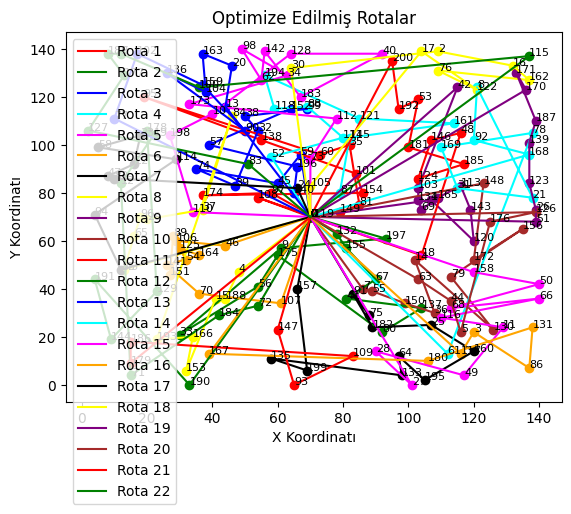

In [133]:
num_sim=100
best_solution_routes, best_solution_cost = run_multiple_simulations(num_sim)
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'orange', 'black', 'yellow', 'purple', 'brown']
fig, ax = plt.subplots()

for i, route in enumerate(best_solution_routes):
    route_cost, fixed_cost = calculate_route_cost(route, customers)
    x = [customers[customer_id]['x'] for customer_id in route]
    y = [customers[customer_id]['y'] for customer_id in route]
    plt.plot(x, y, label=f'Rota {i + 1}', color=colors[i % len(colors)])
    for customer_id in route:
        plt.scatter(customers[customer_id]['x'], customers[customer_id]['y'], color=colors[i % len(colors)])
        plt.annotate(f"{customer_id}", (customers[customer_id]['x'], customers[customer_id]['y']), fontsize=8, color='black')

plt.xlabel('X Koordinatı')
plt.ylabel('Y Koordinatı')
plt.title('Optimize Edilmiş Rotalar')
plt.legend()
plt.show()

In [134]:
print(instance)
print("Deneme Sayısı:", num_sim)
print("######################################")
route_counter = 1
for route in best_solution_routes:
    if len(route) > 2 or (len(route) == 2 and route[0] != route[1]):
        route_cost, fixed_cost = calculate_route_cost(route, customers)
        route.pop(0)
        route.pop(-1)
        route_str = ' '.join(map(str, route))
        print(f"Route #{route_counter}: {route_str}")
        route_counter += 1  # Sadece geçerli rotalar için sayacı artır
print("Cost", best_solution_cost)

instance_18.txt
Deneme Sayısı: 100
######################################
Route #1: 149 81 35 60 95 138 101 154 174 97 119 108
Route #2: 132 155 67 41 137 80 175 56 33 9 197
Route #3: 140 196 57 152 99 38 32 39 74 45 59
Route #4: 87 145 161 121 194 118 88 111 52
Route #5: 73 112 173 34 98 62 142 183 40 128 10 198 110
Route #6: 46 106 54 89 151 125 164 141 70 107
Route #7: 157 199 135 133 64 195 160 25 182 91 75
Route #8: 4 188 15 153 166 193 84 37 29 96 65 43
Route #9: 1 120 143 113 165 69 134 103 42
Route #10: 7 55 150 36 14 130 79 156 172 148
Route #11: 18 48 146 124 185 181 53 192 200
Route #12: 72 184 71 12 19 178 129 144 191 190
Route #13: 13 20 163 104 136 90 159 102 77
Route #14: 168 92 8 21 31 169 78 61
Route #15: 158 50 68 66 116 11 49 28 27
Route #16: 117 3 86 131 180 167
Route #17: 85 94 114 58 23 22 47 82 24
Route #18: 30 2 16 162 76 122 17 105
Route #19: 51 26 123 139 187 171 170
Route #20: 63 44 5 176 126
Route #21: 147 93 109 186 179
Route #22: 115 100 6 189 177 127 83
C